# Portfolio Diversification Based on Clustering Analysis
### Goal
The goal of this project is to use clustering algorithms to create a diversified portfolio in order to reduce volatility and reduce the overall risk of an investment portfolio.

### Import Modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

plt.style.use('ggplot')
%matplotlib inline

### Load Data

In [2]:
# Import S&P500 data
path = '../data/individual_stocks_5yr'
all_rec = glob.iglob(path +'/*.csv', recursive=True)

prices_df = pd.DataFrame()
for f in all_rec:
    df = pd.read_csv(f,index_col='date',usecols=['date','close'])
    colname = os.path.basename(f).split('_')[0]
    df.rename(columns={'close':colname},inplace=True)
    prices_df = pd.concat([prices_df,df],axis=1,sort=False)
prices_df.dropna(axis = 1, inplace=True)

# Split S&P500 data into training period (first four years) and test period (last one year)
prices_test = prices_df.loc["2017-02-08":]
prices_train = prices_df.loc[:"2017-02-07"]
prices_train.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,14.66,66.7156,78.97,35.27,46.64,34.46,73.56,38.81,46.26,31.16,...,37.80,28.42,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,13.99,66.6556,78.84,36.57,46.77,34.70,73.13,38.61,46.54,31.40,...,38.44,28.22,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


### Preprocessing--Get Log Returns

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.019857,0.010368,-0.006485,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,0.001983,...,-0.001334,0.002476,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,-0.013227,-0.025386,0.002675,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,...,0.003198,0.003526,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.026963,-0.001905,0.004696,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,...,0.005837,0.000352,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.046780,-0.000900,-0.001648,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,...,0.016789,-0.007062,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,0.035806,-0.013876,0.002027,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,...,-0.008360,0.015820,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116


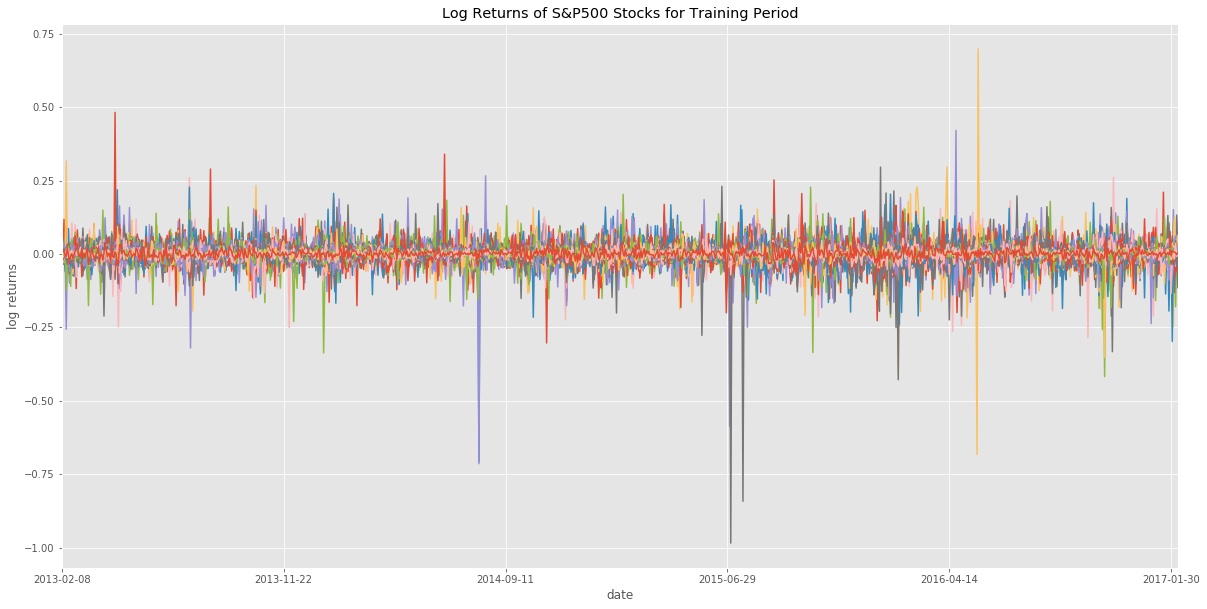

In [3]:
# Compute log returns of S&P500 for the training period
returns = prices_train.pct_change()
returns = np.log(1 + returns)#.mean()*len(returns)
returns = pd.DataFrame(returns)

ax = returns.plot(legend=False, figsize=(20,10))
ax.set_ylabel('log returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')
returns[1:].head()

### Preprocessing--Get Sharpe Ratio

In [4]:
# Compute Sharpe ratio of each stock in S&P500 for the training period
sharpe_ratio = pd.DataFrame(returns[1: ].mean()/returns[1: ].std(),columns = ['Sharpe'])
sharpe_ratio.head()

,Sharpe
AAL,0.047561
AAPL,0.043312
AAP,0.041801
ABBV,0.029539
ABC,0.048295


### Get Log Returns and Sharpe Ratio for Dow Jones Index
Now that preprocessing is done, let's first get benchmarks before we start training. The first benchmark is DJI.

In [5]:
# Import Dow Jones Index Data
DJI = pd.read_csv('../data/DJI.csv',index_col='Date',usecols=['Date','Close'])
DJI.rename(columns={'Close':'close'},inplace=True)
DJI.index.rename('date',inplace=True)

# Get DJI for test period
DJI_test = DJI.loc["2017-02-08":]

# Compute log returns of Dow Jones Index for the test period
DJI_returns = DJI_test.pct_change()
DJI_returns = np.log(1 + DJI_returns)

# Compute Sharpe ratio of Dow Jones Index for the test period
DJI_sharpe = DJI_returns[1:].mean()/DJI_returns[1:].std()
DJI_sharpe

close    0.150174
dtype: float64

### Get Sharpe Ratio of 30 Randomly Selected Stocks
The second benchmark is 30 randomly selected stocks.

In [6]:
# Function to compute Sharpe ratio of a portfolio
def portf_sharpe(portfolio, prices):
    portf_val=np.zeros(len(prices))    
    for stock in portfolio:
        portf_val+=prices[stock]

    portf_returns = portf_val.pct_change()
    portf_returns = np.log(1 + portf_returns)

    portf_sharpe = portf_returns[1:].mean()/portf_returns[1:].std()
    return portf_sharpe

# Compute average Sharpe ratio for 30 portfolios of 30 randomly selected stocks
iter = range(30)
sum = 0
for i in iter:
    np.random.seed(i)
    rand_idx=np.random.randint(0,470,30)
    rand_portf = returns.columns[rand_idx]
    sum += portf_sharpe(rand_portf,prices_test)
sharpe_random = sum / 30
sharpe_random

0.10206522940935835

### Construct Portfolio by K Means Clustering
First, fit K Means clustering with 30 clusters. Then group stocks construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster. Since only Euclidean distances are allowed for k-means clustering in scikit-learn, we will use stock prices in each day as features.

In [7]:
# Fit K means clustering to S&P500 data for the training period with k=30
X = returns[1:].transpose()
groups = KMeans(n_clusters=30,random_state=0).fit_predict(X)

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_kmeans = portf_sharpe(portfolio['Sharpe'], prices_test) # > 0.046057 (DJI Sharpe)
sharpe_kmeans

0.12244698439060463

### Correlation Matrix
We will be using correlation distance between each stock's price history for hierarchical clustering, so let's create our correlation matrix and visualize how our clustering results would look like. We expect using correlation to perform better than using prices in each day, because it can take into account not only similarities in prices but also similarities in trends in which the prices are moving. The heatmap does not represent the actual 30 clusters we are constructing, but rather visualizes the results of our practice in more general sense.

In [8]:
# Function to create correlation matrix
def calcCorr(myReturns):
    col = myReturns.columns
    cor1 = np.corrcoef(myReturns,rowvar=0)
    cor = pd.DataFrame(cor1, columns = col, index = col)
    return cor

# Create correlation matrix of log returns for the training period
corrmat = calcCorr(returns[1: ])
corrmat.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
AAL,1.000000,0.200675,0.225991,0.248768,0.234620,0.308229,0.305795,0.326167,0.325411,0.253109,...,0.263861,0.327274,0.177203,0.325831,0.259953,0.300794,0.242517,0.263886,0.326531,0.261420
AAPL,0.200675,1.000000,0.176319,0.186406,0.145272,0.278286,0.290020,0.282241,0.394607,0.203475,...,0.227481,0.252621,0.260023,0.288658,0.247788,0.264304,0.240567,0.293319,0.273403,0.246585
AAP,0.225991,0.176319,1.000000,0.261678,0.172290,0.331106,0.252668,0.282411,0.265221,0.293869,...,0.254881,0.280136,0.231542,0.287630,0.239369,0.291905,0.233736,0.273436,0.295131,0.195845
ABBV,0.248768,0.186406,0.261678,1.000000,0.366676,0.439151,0.279692,0.310347,0.320934,0.303770,...,0.300882,0.258262,0.298423,0.367174,0.269840,0.298857,0.184242,0.408745,0.297363,0.379067
ABC,0.234620,0.145272,0.172290,0.366676,1.000000,0.379403,0.289795,0.230713,0.216552,0.188424,...,0.199846,0.315002,0.225259,0.311235,0.200092,0.221100,0.172375,0.244498,0.266225,0.293084


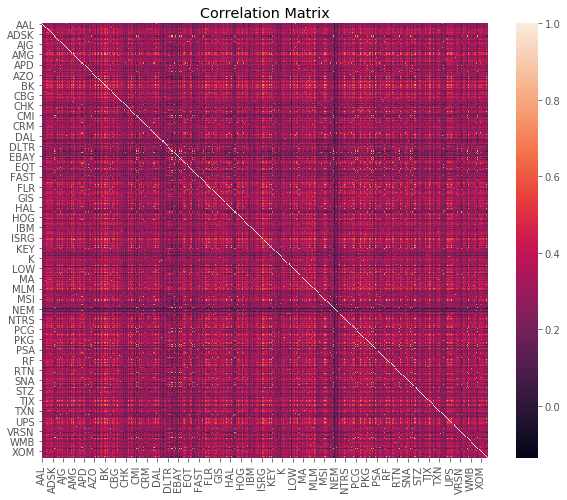

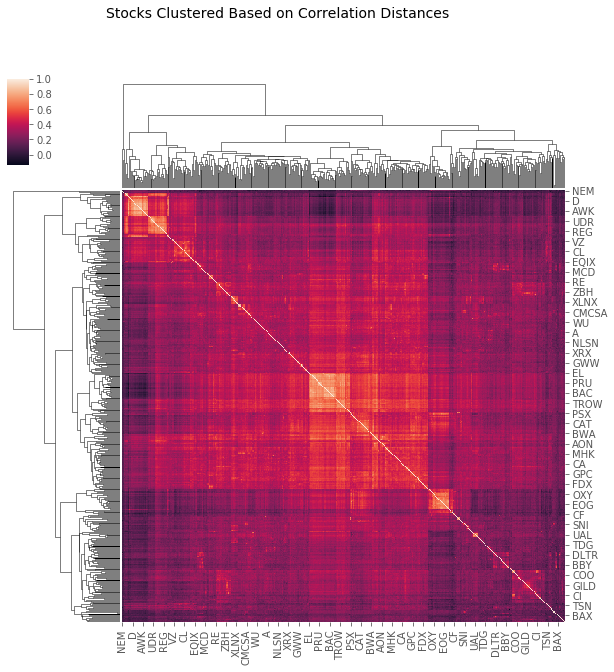

In [9]:
import seaborn as sns

plt.figure(figsize=(10,8))

# Create a heatmap of the correlation matrix
sns.heatmap(corrmat)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corrmat, method='average', figsize=(10,10)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14);

In [10]:
# Function to create distance matrix by correlation
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = 1 - corr
    return dist

D = correlDist(corrmat)

In [11]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = single'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'single')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_single = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_single

0.11100963834227907

### Hierarchical (Agglomerative) Clustering

In [12]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = complete'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'complete')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_complete = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_complete

0.08597243569311243

In [13]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = average'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'average')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_average = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_average

0.08912229235480079

### Compare Sharpe Ratios

In [14]:
benchmarks = pd.DataFrame([[DJI_sharpe['close'], sharpe_random]])
benchmarks.rename(columns={0:'DJI', 1:'Random'}, index={0:'Sharpe ratio'}, inplace=True)

portfolios = pd.DataFrame([[sharpe_kmeans, sharpe_single, sharpe_complete, sharpe_average]])
portfolios.rename(columns={0:'KMeans', 1:'Single', 2:'Complete', 3:'Average'}, index={0:'Sharpe ratio'}, inplace=True)

benchmarks

,DJI,Random
Sharpe ratio,0.150174,0.102065


In [15]:
portfolios

,KMeans,Single,Complete,Average
Sharpe ratio,0.122447,0.11101,0.085972,0.089122


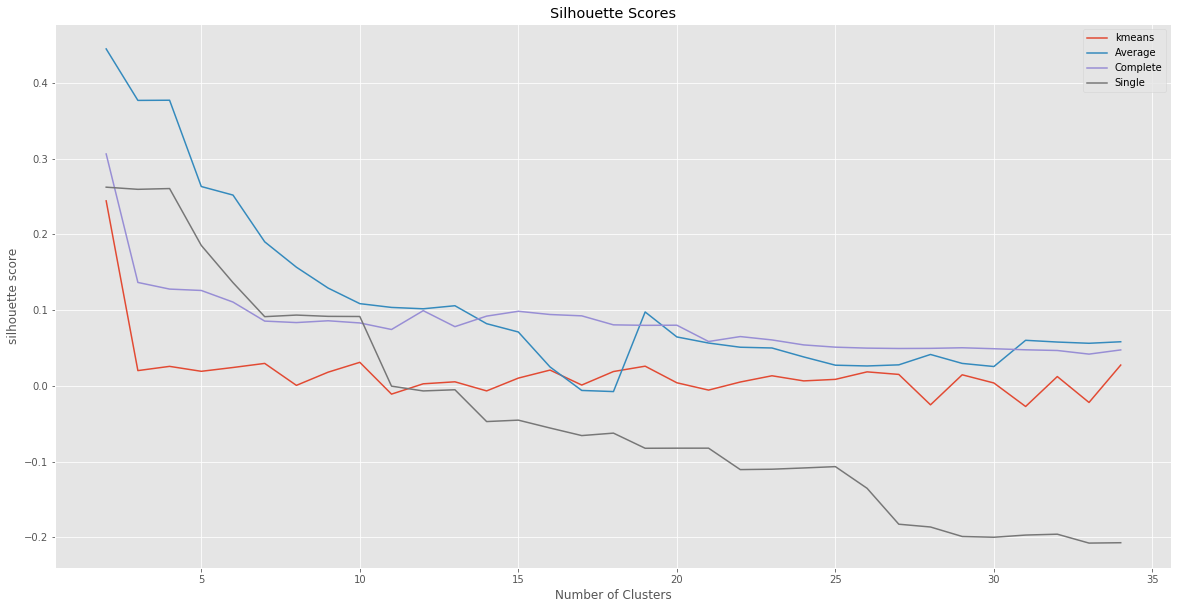

In [16]:
from sklearn.metrics import silhouette_score

# Create an array for the range of number of clusters
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster with different k's and plot
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(X)
    score = silhouette_score(X,labels)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = average' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'average')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = complete' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'complete')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = single' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'single')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Average','Complete','Single']);

### Change to Shorter Training Period
The results above does not seem consistent with our expectations nor the silhouette scores. Unlike what we expected, k-means clustering has the highest Sharpe ratio followed by single linkage. Silhouette scores suggest the worst performance for single linkage. It may be because we are adding noise by using training data from too long ago. Stock prices from 5 years ago may not necessarily be consistent with the prices today. Let's try using shorter training period and see if it works better.

In [17]:
prices_train = prices_df.loc["2016-02-07":"2017-02-07"]

# Compute log returns of S&P500 for the training period
returns = prices_train.pct_change()
returns = np.log(1 + returns)#.mean()*len(returns)
returns = pd.DataFrame(returns)

In [18]:
# Fit K means clustering to S&P500 data for the training period with k=30
X = returns[1:].transpose()
groups = KMeans(n_clusters=30,random_state=0).fit_predict(X)

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_kmeans = portf_sharpe(portfolio['Sharpe'], prices_test) # > 0.046057 (DJI Sharpe)
sharpe_kmeans

0.09472754231737152

In [19]:
corrmat = calcCorr(returns[1: ])
D = correlDist(corrmat)

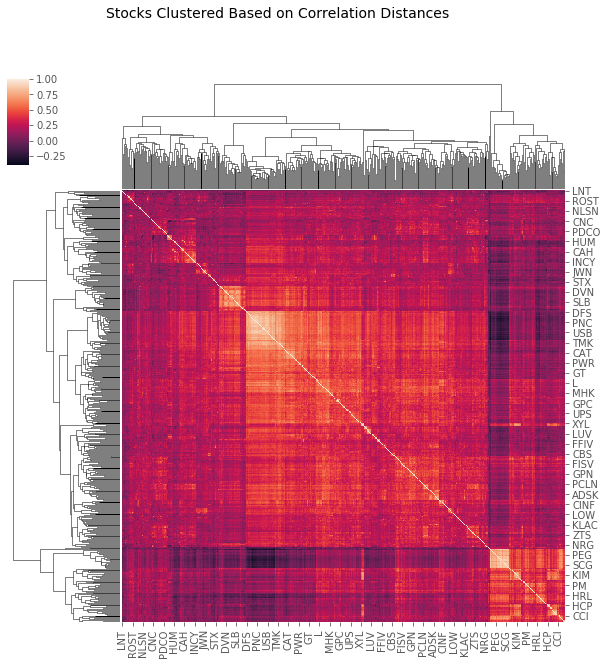

In [20]:
# Create a clustermap
sns.clustermap(corrmat, method='average', figsize=(10,10)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14);

In [21]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = single'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'single')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_single = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_single

0.0753779493216984

In [22]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = complete'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'complete')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_complete = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_complete

0.1154748759522522

In [23]:
# Fit Agglomerative clustering with n_clusters=30, precomputed custom distance matrix, and 'linkage = average'
agg = AgglomerativeClustering(n_clusters=30, affinity = 'precomputed',linkage = 'average')
groups = agg.fit_predict(D)  # Returns class labels.

# Group stocks in S&P500 by the 30 clusters and construct a portfolio with by selecting the stock with highest Sharpe ratio from each cluster
df = pd.DataFrame(groups, index=prices_train.columns, columns = ['Group'])
df = pd.concat([df, sharpe_ratio], axis=1)
portfolio = df.groupby(['Group']).idxmax()

# Compute Sharpe ratio of the portfolio
sharpe_average = portf_sharpe(portfolio['Sharpe'],prices_test)
sharpe_average

0.12596308456493488

### Compare Sharpe Ratios

In [24]:
portfolios = pd.DataFrame([[sharpe_kmeans, sharpe_single, sharpe_complete, sharpe_average]])
portfolios.rename(columns={0:'KMeans', 1:'Single', 2:'Complete', 3:'Average'}, index={0:'Sharpe ratio'}, inplace=True)

benchmarks

,DJI,Random
Sharpe ratio,0.150174,0.102065


In [25]:
portfolios

,KMeans,Single,Complete,Average
Sharpe ratio,0.094728,0.075378,0.115475,0.125963


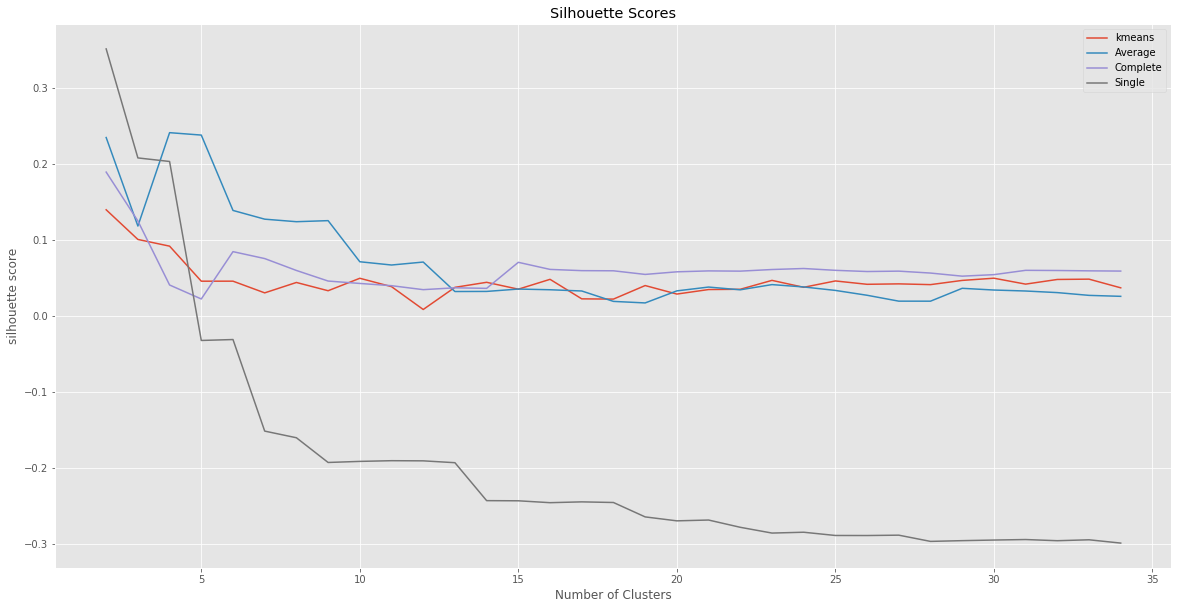

In [26]:
# Create an array for the range of number of clusters
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster with different k's and plot
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(X)
    score = silhouette_score(X,labels)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = average' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'average')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = complete' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'complete')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = single' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k, affinity = 'precomputed',linkage = 'single')
    labels = ag.fit_predict(D)
    score = silhouette_score(D,labels)
    scores.append(score)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Average','Complete','Single']);

The results look much more consistent with our expectations and silhouette scores.

### Annualized Volatility

In [27]:
# Compute log returns of S&P500 for the test period
test_returns = prices_test.pct_change()
test_returns = np.log(1 + test_returns)#.mean()*len(returns)
test_returns = pd.DataFrame(test_returns)

In [28]:
# Compute market volatility using S&P500 for the test period
from math import sqrt
weights = np.ones(len(test_returns.columns))*(1/len(test_returns.columns))
sp500_vol = sqrt(np.dot(weights.T,np.dot(test_returns.cov()*252,weights)))
sp500_vol

0.0858993251309291

In [29]:
# Dataframe of returns of each stock included in the portfolio
portf_df = pd.DataFrame()
for stock in rand_portf:
    portf_df = pd.concat([portf_df,test_returns[stock]],axis=1,sort=False)

# Compute portfolio volatility
weights = np.ones(len(portf_df.columns))*(1/len(portf_df.columns))
rand_vol = sqrt(np.dot(weights.T,np.dot(portf_df.cov()*252,weights)))
rand_vol

0.08164333856046802

In [30]:
# Compute average volatility for 30 portfolios of 30 randomly selected stocks
iter = range(30)
sum = 0
for i in iter:
    np.random.seed(i)
    rand_idx=np.random.randint(0,470,30)
    rand_portf = returns.columns[rand_idx]
    portf_df = pd.DataFrame()
    for stock in rand_portf:
        portf_df = pd.concat([portf_df,test_returns[stock]],axis=1,sort=False)

    # Compute portfolio volatility
    weights = np.ones(len(portf_df.columns))*(1/len(portf_df.columns))
    rand_vol = sqrt(np.dot(weights.T,np.dot(portf_df.cov()*252,weights)))
    sum += rand_vol
rand_vol = sum / 30
rand_vol

0.09269888800187755

In [31]:
# Dataframe of returns of each stock included in the portfolio
portf_df = pd.DataFrame()
for stock in portfolio['Sharpe']:
    portf_df = pd.concat([portf_df,test_returns[stock]],axis=1,sort=False)

# Compute portfolio volatility
weights = np.ones(len(portf_df.columns))*(1/len(portf_df.columns))
portf_vol = sqrt(np.dot(weights.T,np.dot(portf_df.cov()*252,weights)))
portf_vol

0.08980980188670691

In [32]:
# Compute volatility for each cluster
clusters = df.groupby(['Group']).groups
cnt = 0
vols = []
for i in range(30):    
    cluster_df = pd.DataFrame()
    for c in clusters[i]:
        cluster_df = pd.concat([cluster_df,test_returns[c]],axis=1,sort=False)
    weights = np.ones(len(cluster_df.columns))*(1/len(cluster_df.columns))
    cluster_vol = sqrt(np.dot(weights.T,np.dot(cluster_df.cov()*252,weights)))
    vols.append(cluster_vol)
    if(cluster_vol < portf_vol):
        cnt+=1

# Average of cluster volatilities
average_vol = np.asarray(vols).mean()
average_vol

0.19217112161678085

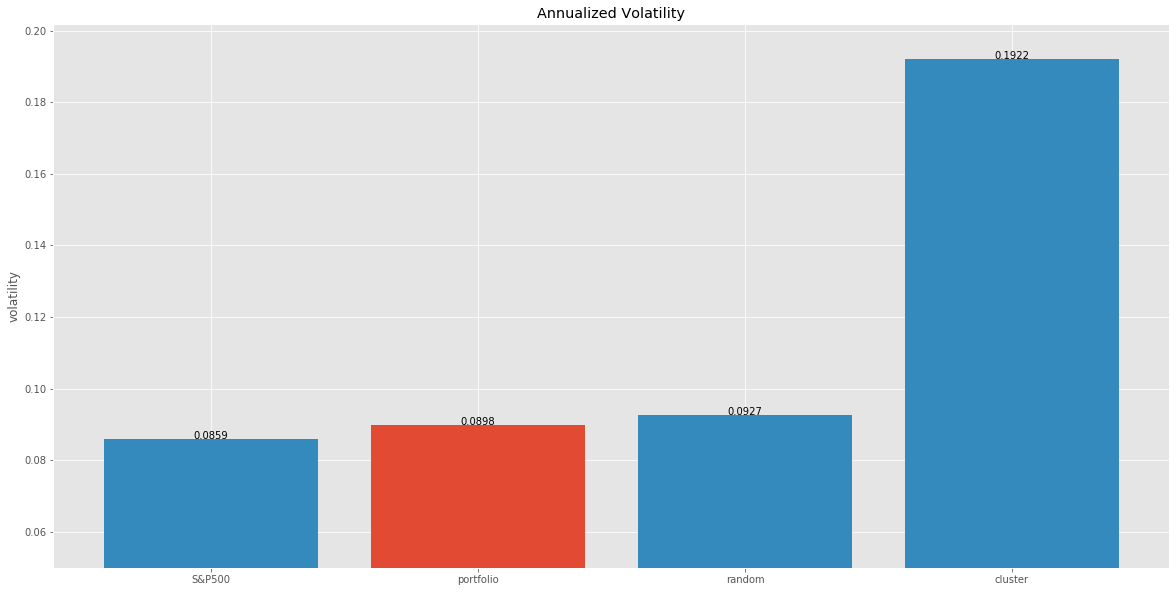

In [33]:
# Plot a bar chart of market volatility, portfolio volatiliy, and cluster volatility
vol = pd.DataFrame.from_dict({'S&P500':sp500_vol, 'portfolio':portf_vol, 'random':rand_vol, 'cluster':average_vol}, orient='index', columns=['volatility'])

plt.figure(figsize=(20,10))
ax = plt.bar(height='volatility', x=vol.index, data=vol, color=['C1','C0','C1','C1'])
rects = ax.patches
for rect, val in zip(rects,vol['volatility']):
    height = rect.get_height()
    plt.annotate('{:.4f}'.format(val), (rect.get_x() + rect.get_width() / 2, height), ha='center')
plt.ylim(bottom=.05)
plt.ylabel('volatility')
plt.title('Annualized Volatility');

Taking into consideration that our S&P500 data is composed of 470 companies, we can claim that the volatility of our portfolio is satisfying. Our model also performs better than random selection both in terms of Sharpe ratio and volatility. 

In [34]:
# Count number of clusters with lower volatility than portfolio consturcted
cnt=0
for v in vols:
    if v < portf_vol: cnt += 1

print('{} out of 30 clusters have lower volatility that the portfolio constructed.'.format(cnt))

1 out of 30 clusters have lower volatility that the portfolio constructed.


### Suggestions for Improvements/Further Studies
- Other metrics can be used as alternatives of Sharpe Ratio: Sortino Ratio, Value-at-Risk
- Adjust length of training period and number of clusters
- Change/extend pool of stocks: since we are only selecting stocks from S&P500, they are all large companies and may have similarities to some extent. This may be the reason why silhouette scores for smaller number of clusters are higher.
- Implement distance thresholds
- Improve on the risk-return of the portfolio by: assigning weights on each stock of the portfolio based on an optimization problem to maximize Sharpe ratio
- Add/utilize industry sector information for each company
- Use time series analysis to describe the changes in stock prices throughout the duration